In [12]:
fidx = 'hill_'
midx = 'g100c'
midx0 = 'g100c'

import numpy as np
import pickle

mnames = ['hill_g100']
weights = [1]

# pytorch models with folds

hlist = mnames

glist = ['air_m68','airx_m67','cbam_m67','preresnet_m67']

dlist0 = ['airnet50_gwap','airnet50_gwap','airnext50_gwap','airnext50_gwap',
          'bn_inception_wgap','dpn68_gwap','resnet34_gwap',
          'se_resnext50_gwap']
dlist1 = ['ch_018','ch_028','ch_018','ch_030',
          'ch_042','ch_030','ch_042',
          'ch_030']

dlist = [i+'_'+j for i,j in zip(dlist0,dlist1)]

glist += dlist


In [13]:
# # list of unique model names
# allm = [weights[i]['mod'].values for i in range(len(weights))]
# mnames = list(set().union(*allm))
print(mnames)
print(len(mnames))

['hill_g100']
1


In [14]:
nfold = 2
threshold = 0.45
sub_dir = './sub/'

print(fidx,midx,nfold,len(mnames))

hill_ g100c 2 1


In [15]:
blist = ['blend_0459']
tlist = ['iv3_a4','se_resnext_d10','se_resnext_d11']
klist = ['resnet34_46','resnet50','resnet34']
print(glist)
print(blist)
print(tlist)
print(klist)

gpct = 97.5
gscale = 1.

['air_m68', 'airx_m67', 'cbam_m67', 'preresnet_m67', 'airnet50_gwap_ch_018', 'airnet50_gwap_ch_028', 'airnext50_gwap_ch_018', 'airnext50_gwap_ch_030', 'bn_inception_wgap_ch_042', 'dpn68_gwap_ch_030', 'resnet34_gwap_ch_042', 'se_resnext50_gwap_ch_030']
['blend_0459']
['iv3_a4', 'se_resnext_d10', 'se_resnext_d11']
['resnet34_46', 'resnet50', 'resnet34']


In [16]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit, expit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

import scipy.optimize as opt

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

In [17]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
LABEL_MAP = name_label_dict
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [18]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [19]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [20]:
test_df.columns

Index(['Predicted'], dtype='object')

In [21]:
# save a base copy for reuse below
test_df0 = test_df.copy()


In [23]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values
num_classes = 28
firstm = True
sumw = 0.
d = 0
for m in mnames:

    firstf = True
    navg = 0
    if m in blist: suffix = '.npy'
    elif m in klist: suffix = '.pkl'
    elif m in hlist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            elif m in dlist:
                if dlist0[d] == 'bn_inception_wgap': s = '_emb'
                else: s = '_extra_emb'
                fname = 'oof/Dmytro/'+dlist0[d]+s+'__fold_'+ \
                                str(fold)+'_'+dlist1[d]+'_test.csv'
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                elif m in dlist:
                    o = pd.read_csv(fname)
                    idb = list(o['Id'])
                    ptestb = np.array(o.iloc[:,:num_classes])
                    ptestb = expit(ptestb)
                elif m in glist:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = np.percentile(ptestb, gpct, axis=(2,3))
                    ptestb = 1./(1. + np.exp(-ptestb/gscale))
                elif m in hlist:
                    idb, ptestb = pickle.load(open(fname,'rb'))
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                
            navg += 1
    
    if navg != nfold: raise ValueError('Found %d folds for %s instead of %d' % (navg,m,nfold))
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)
    if m in dlist: d += 1



./sub/hill_g100_0.pkl
2.0646003494022017e-09 0.12257564719219768 0.9999954168626155
(11702, 28) 2.0646003494022017e-09 0.12257564719219768 0.9999954168626155

./sub/hill_g100_1.pkl
4.685959138740213e-08 0.1296316769557789 0.999959899333665
(11702, 28) 4.685959138740213e-08 0.1296316769557789 0.999959899333665
[[1.    0.955]
 [0.955 1.   ]]
hill_g100 2 (11702, 28) 1.241353023026882e-06 0.1261036620739883 0.9999378884622834 0.1010144785995068


In [24]:
test_df.columns

Index(['Predicted', 'hill_g100'], dtype='object')

In [25]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [26]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    ff = np.array(list(test_df[c])).flatten()
    print(ff.shape,c)
    f.append(ff)
# print(clist)
r = np.corrcoef(f)
print(r)

(327656,) hill_g100
1.0


In [27]:
if len(mnames) > 1:
    d = pd.DataFrame(r, columns=mnames)
    d['id'] = mnames
    d.set_index('id',inplace=True)
    del d.index.name

    sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [28]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 1)
flat.csv


In [29]:
ens = np.zeros((test_df.shape[0],28))

# apply class-specific ensemble weights
for i in range(28):

    f = []
#     clist = weights[i]['mod'].values
    clist = mnames
    for c in clist:
        f.append(np.array(list(test_df[c])))
    m = np.array(f)
    print(m.shape)

#     w = np.array(weights[i]['weight'].values)
    w = np.array(weights)
    print(i, clist, w)

    ens[:,i] = np.average(m,axis=0,weights=w)[:,i]
    
print(ens.shape)

(1, 11702, 28)
0 ['hill_g100'] [1]
(1, 11702, 28)
1 ['hill_g100'] [1]
(1, 11702, 28)
2 ['hill_g100'] [1]
(1, 11702, 28)
3 ['hill_g100'] [1]
(1, 11702, 28)
4 ['hill_g100'] [1]
(1, 11702, 28)
5 ['hill_g100'] [1]
(1, 11702, 28)
6 ['hill_g100'] [1]
(1, 11702, 28)
7 ['hill_g100'] [1]
(1, 11702, 28)
8 ['hill_g100'] [1]
(1, 11702, 28)
9 ['hill_g100'] [1]
(1, 11702, 28)
10 ['hill_g100'] [1]
(1, 11702, 28)
11 ['hill_g100'] [1]
(1, 11702, 28)
12 ['hill_g100'] [1]
(1, 11702, 28)
13 ['hill_g100'] [1]
(1, 11702, 28)
14 ['hill_g100'] [1]
(1, 11702, 28)
15 ['hill_g100'] [1]
(1, 11702, 28)
16 ['hill_g100'] [1]
(1, 11702, 28)
17 ['hill_g100'] [1]
(1, 11702, 28)
18 ['hill_g100'] [1]
(1, 11702, 28)
19 ['hill_g100'] [1]
(1, 11702, 28)
20 ['hill_g100'] [1]
(1, 11702, 28)
21 ['hill_g100'] [1]
(1, 11702, 28)
22 ['hill_g100'] [1]
(1, 11702, 28)
23 ['hill_g100'] [1]
(1, 11702, 28)
24 ['hill_g100'] [1]
(1, 11702, 28)
25 ['hill_g100'] [1]
(1, 11702, 28)
26 ['hill_g100'] [1]
(1, 11702, 28)
27 ['hill_g100'] [1]
(1

In [30]:
print(ens[1])

[0.271 0.013 0.088 0.142 0.102 0.987 0.117 0.029 0.001 0.001 0.005 0.048 0.013 0.025 0.012 0.002
 0.016 0.007 0.038 0.019 0.012 0.093 0.014 0.089 0.13  0.667 0.053 0.001]


In [31]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [32]:
# desired class proportions from lb probing

desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : 0.0018,
9 : 0.0014,
10 : 0.0009,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : 0.0007,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : 0.0056,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : 0.0104,
25 : 0.222493888,
26 : 0.028806584,
27 : 0.0004
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.0018, 9: 0.0014, 10: 0.0009, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.0007, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.0056, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.0104, 25: 0.222493888, 26: 0.028806584, 27: 0.0004}


In [33]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold 0.45
0 0.3624 0.6484 Nucleoplasm
1 0.0438 0.0569 Nuclear membrane
2 0.0753 0.1221 Nucleoli
3 0.0593 0.0757 Nucleoli fibrillar center
4 0.0753 0.0790 Nuclear speckles
5 0.0753 0.1119 Nuclear bodies
6 0.0438 0.0643 Endoplasmic reticulum
7 0.0753 0.1118 Golgi apparatus
8 0.0018 0.0015 Peroxisomes
9 0.0014 0.0021 Endosomes
10 0.0009 0.0022 Lysosomes
11 0.0438 0.0494 Intermediate filaments
12 0.0438 0.0628 Actin filaments
13 0.0142 0.0224 Focal adhesion sites
14 0.0438 0.0690 Microtubules
15 0.0007 0.0005 Microtubule ends
16 0.0288 0.0469 Cytokinetic bridge
17 0.0142 0.0829 Mitotic spindle
18 0.0288 0.0780 Microtubule organizing center
19 0.0593 0.1083 Centrosome
20 0.0056 0.0068 Lipid droplets
21 0.1261 0.2624 Plasma membrane
22 0.0288 0.0439 Cell junctions
23 0.0753 0.1063 Mitochondria
24 0.0104 0.0154 Aggresome
25 0.2225 0.5611 Cytosol
26 0.0288 0.0353 Cytoplasmic bodies
27 0.0004 0.0010 Rods & rings


In [34]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

from scipy.special import expit

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

pred_t = expit(ens)
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
np.set_printoptions(precision=3, suppress=True, linewidth=100)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))
pred = (pred_t > th_t).astype(int)

Thresholds:  [0.705 0.676 0.683 0.656 0.632 0.661 0.663 0.675 0.596 0.597 0.598 0.651 0.663 0.686 0.694 0.593
 0.674 0.726 0.708 0.687 0.621 0.692 0.674 0.67  0.694 0.709 0.654 0.595]
Fractions:  [0.455 0.047 0.081 0.059 0.071 0.074 0.043 0.079 0.002 0.002 0.002 0.043 0.042 0.016 0.049 0.001
 0.029 0.014 0.033 0.065 0.006 0.138 0.03  0.078 0.011 0.263 0.027 0.001]
Fractions (th = 0.5):  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [35]:
ens.shape

(11702, 28)

In [36]:
p = pd.DataFrame(ens)
p.columns = ['p'+str(i) for i in range(ens.shape[1])]
subp = pd.DataFrame({'id':test_df.index.values,'data':'sub'})
subp = pd.concat((subp,p),axis=1)
print(subp.shape)
fname = 'sub/sub' + midx + '_probs.csv'
subp.to_csv(fname, index=False)
print(fname)

(11702, 30)
sub/subg100c_probs.csv


In [37]:
# get frequencies from best submission
best_sub = pd.read_csv('sub/b650.csv')
s0 = [s if isinstance(s, str) else '' for s in best_sub.Predicted]
p0 = [s.split() for s in s0]
y0 = np.zeros((best_sub.shape[0], 28)).astype(int)
for i in range(best_sub.shape[0]):
    for j in p0[i]: y0[i, int(j)] = 1

desired = {}
for i in range(28):
    desired[i] = y0[:,i].mean()
    
# # override majority classes
# desired[0] = 0.37
# desired[25] = 0.24

In [38]:
# custom thresholds to match best sub proportions
thresholds = np.linspace(0.99, 0.01, 100001)
pred = ens.copy()
th = []
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    th.append(t)
    print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j])

0 0.8665 0.4583 0.4583 Nucleoplasm
1 0.8137 0.0447 0.0447 Nuclear membrane
2 0.7271 0.0856 0.0856 Nucleoli
3 0.6986 0.0553 0.0553 Nucleoli fibrillar center
4 0.6418 0.0649 0.0649 Nuclear speckles
5 0.6665 0.0740 0.0740 Nuclear bodies
6 0.7193 0.0404 0.0404 Endoplasmic reticulum
7 0.6925 0.0821 0.0821 Golgi apparatus
8 0.6241 0.0012 0.0012 Peroxisomes
9 0.8902 0.0018 0.0018 Endosomes
10 0.8070 0.0017 0.0017 Lysosomes
11 0.6446 0.0428 0.0428 Intermediate filaments
12 0.7929 0.0369 0.0369 Actin filaments
13 0.8282 0.0153 0.0153 Focal adhesion sites
14 0.9038 0.0447 0.0447 Microtubules
15 0.9900 0.0004 0.0004 Microtubule ends
16 0.7784 0.0267 0.0267 Cytokinetic bridge
17 0.9437 0.0177 0.0177 Mitotic spindle
18 0.8837 0.0337 0.0337 Microtubule organizing center
19 0.8263 0.0598 0.0598 Centrosome
20 0.8037 0.0052 0.0052 Lipid droplets
21 0.7836 0.1475 0.1475 Plasma membrane
22 0.7384 0.0301 0.0301 Cell junctions
23 0.6435 0.0853 0.0853 Mitochondria
24 0.9139 0.0108 0.0108 Aggresome
25 0.8622

In [39]:
# # custom thresholds to match lb proportions
# thresholds = np.linspace(1.0, 0., 100001)
# pred = ens.copy()
# th = []
# for j in range(pred.shape[1]):
#     for t in thresholds:
#         pred[:,j] = (ens[:,j] > t).astype(int)
#         prop = np.mean(pred[:,j])
#         if prop >= desired[j]: break
#     th.append(t)
#     print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j])

In [40]:
# bestCut = pickle.load(open('ens_cuts'+midx0+'.pkl','rb'))
# th = np.array(th)
# c = bestCut**2 + th**2

# fig, ax = plt.subplots()
# ax.scatter(bestCut, th, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]

# # now plot both limits against each other
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)
# # fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [41]:
# # shrink thresholds toward best ones from oofs
# alpha = 0.8
# pred = ens > (alpha*th + (1.-alpha)*bestCut)

In [42]:
# # linear adjustment of thresholds estimated in ens_oof.ipynb
# for j in range(pred.shape[1]):
#     t = 0.094 + 0.827*th[j]
#     pred[:,j] = (ens[:,j] > t).astype(int)
#     prop = np.mean(pred[:,j])
#     print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j])

In [43]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [44]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.7851649290719536 6.0


In [45]:
print(sum(xps==0)/pred.shape[0])

0.02922577337207315


In [46]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3 5
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 3 23 25
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 21 25
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 0 21 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '5', '0 5 25', '0', '', 

In [47]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/hill_g100c.csv


In [48]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 5363 prop 0.4583
1 Nuclear membrane count 523 prop 0.0447
2 Nucleoli count 1002 prop 0.0856
3 Nucleoli fibrillar center count 647 prop 0.0553
4 Nuclear speckles count 760 prop 0.0649
5 Nuclear bodies count 866 prop 0.0740
6 Endoplasmic reticulum count 473 prop 0.0404
7 Golgi apparatus count 961 prop 0.0821
8 Peroxisomes count 14 prop 0.0012
9 Endosomes count 21 prop 0.0018
10 Lysosomes count 20 prop 0.0017
11 Intermediate filaments count 501 prop 0.0428
12 Actin filaments count 432 prop 0.0369
13 Focal adhesion sites count 179 prop 0.0153
14 Microtubules count 523 prop 0.0447
15 Microtubule ends count 5 prop 0.0004
16 Cytokinetic bridge count 313 prop 0.0267
17 Mitotic spindle count 207 prop 0.0177
18 Microtubule organizing center count 394 prop 0.0337
19 Centrosome count 700 prop 0.0598
20 Lipid droplets count 61 prop 0.0052
21 Plasma membrane count 1726 prop 0.1475
22 Cell junctions count 352 prop 0.0301
23 Mitochondria count 998 prop 0.0853
24 Aggresome count 126

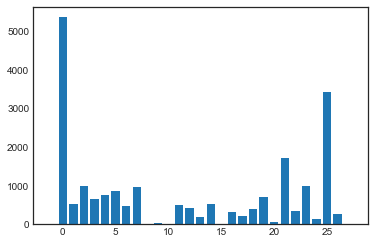

In [49]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [50]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


# computute confusion matrices between two submission files
def f1_confusion(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
    
    y0avg = np.average(y0,axis=0)
    y1avg = np.average(y1,axis=0)
    cm = [confusion_matrix(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    fm = [f1_score(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    for i in range(y0.shape[1]):
        print(LABEL_MAP[i])
        print(cm[i],' %4.2f' % fm[i],' %6.4f' % y0avg[i],' %6.4f' % y1avg[i],
             ' %6.4f' % (y0avg[i] - y1avg[i]))
        print()
#     print('y0avg')
#     print(y0avg)
#     print('y1avg')
#     print(y1avg)
#     print('y0avg - y1avg')
#     print(y0avg-y1avg)
    print('f1 macro')
    print(np.mean(fm))       
    return f1_score(y0, y1, average='macro')
    
# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [51]:
f1_sub(fname,'sub/ens71.csv')

0.8231518309756627

In [52]:
f1_sub(fname,'sub/ens71d.csv')

0.827580758596303

In [53]:
f1_sub(fname,'sub/ens76.csv')

0.8261903071529174

In [54]:
f1_sub(fname,'sub/ens85.csv')

0.837267196998984

In [55]:
f1_sub(fname,'sub/ens85b.csv')

0.8492898840717839

In [56]:
f1_sub(fname,'sub/ens86b.csv')

0.8377391025026782

In [57]:
f1_sub(fname,'sub/ens87b.csv')

0.8414418824091422

In [58]:
f1_sub(fname,'sub/ens88b.csv')

0.8251745231417542

In [59]:
f1_sub(fname,'sub/ens89b.csv')

0.8238107450856365

In [60]:
f1_sub(fname,'sub/ens92b.csv')

0.8516161499727612

In [61]:
f1_sub(fname,'sub/ens92c.csv')

0.8641723315160998

In [62]:
f1_sub(fname,'sub/hill_b92.csv')

0.8292030831273254

In [85]:
f1_sub(fname,'sub/hill_b93.csv')

0.8301247718459327

In [63]:
f1_sub(fname,'sub/hill_m92.csv')

0.8462150285650257

In [64]:
f1_sub(fname,'sub/hill_m94.csv')

0.8384224875821891

In [65]:
f1_sub(fname,'sub/hill_m95c.csv')

0.9508020618948362

In [66]:
f1_sub(fname,'sub/hill_m96c.csv')

0.922611488800044

In [67]:
f1_sub(fname,'sub/hill_m97c.csv')

0.9362484817963274

In [86]:
f1_sub(fname,'sub/hill_m100c.csv')

0.933544421027434

In [68]:
f1_sub(fname,'sub/hill_u94.csv')

0.8407864328431581

In [69]:
f1_sub(fname,'sub/hill_u94c.csv')

0.8750735076373718

In [70]:
f1_sub(fname,'sub/hill_u95c.csv')

0.8791892235077562

In [87]:
f1_sub(fname,'sub/hill_u97c.csv')

0.8773506124452978

In [71]:
f1_sub(fname,'sub/preresnet0.csv')

0.7892765590986309

In [72]:
f1_sub(fname,'sub/preresnet0d.csv')

0.7952565777775663

In [73]:
f1_sub(fname,'sub/resnet11.csv')

0.6254989318783003

In [74]:
f1_sub(fname,'sub/resnet12.csv')

0.6588586842341674

In [75]:
f1_sub(fname,'sub/resnet13.csv')

0.6515930570067853

In [76]:
f1_sub(fname,'sub/resnet15.csv')

0.7566919561274762

In [77]:
f1_sub(fname,'sub/resnet15c.csv')

0.7612927923965127

In [78]:
f1_sub(fname,'sub/resnet16.csv')

0.6982408516289126

In [79]:
f1_sub(fname,'sub/resnet17.csv')

0.7922804644327568

In [80]:
f1_sub(fname,'sub/resnet17.csv')

0.7922804644327568

In [81]:
f1_sub(fname,'sub/se_resnext11.csv')

0.7493108270438026

In [82]:
f1_sub(fname,'sub/se_resnext11d.csv')

0.7527447938060987

In [83]:
print(fname)

sub/hill_g100c.csv


In [84]:
# f1_confusion(fname, 'sub/ens56.csv')